# XGBoost in Compressed Space for Single-Cell Perturbations 

## Context

- Competition context: https://www.kaggle.com/competitions/open-problems-single-cell-perturbations/overview

- Data context: https://www.kaggle.com/competitions/open-problems-single-cell-perturbations/data

# Introduction

Recent advances in single-cell technologies offer new insights into the complex functions of the human body's cells, but leveraging this knowledge for drug development requires linking chemical perturbations and cell state changes. The **"Open Problems – Single-Cell Perturbations"** competition proposes accurately predicting changes in gene expression in diverse cell types and treatments. The results obtained in this competition might be a step forward in the fast development of new medicines using Machine Learning.

In this project, we built an XGBoost model to tackle a multi-output regression challenge. *Noteworthy for its computational efficiency and robustness to dataset noise, our approach operates effectively within a compressed space.*  Our model allows estimation of compound impact on gene expression in a target cell type by leveraging averages from other cells in the compressed space. This approximation can serve as a valuable baseline for training advanced models without prior biological knowledge.

#### Goal 

In this project, we aimed to build a simple and accurate ML model to predict differential gene expression for different cell types affected by various chemical substances (referred to further as "drugs"). 


*Note*: We did not integrate any prior biological knowledge for feature augmentation, i.e. feature engineering was done using only cell type, chemical compound name, and 18211 gene differential expression from `de_train.parquet`. 

> Here **differential gene expression (DE)**  is  a value $-\log_{10}(\text{p-value}) * \text{sign} \left(\log_2  \frac{\text{gene expression (treatment) }} { \text{gene expression (control)} } \right)$ per compared conditions.


#### Performance 

Without ensembling with other models, our method gives `0.594` for public and `0.777` for private scores (time of computing is around 3 min). Bagging of XGB will give an additional insignificant improvement in the scores. 

# Project Structure 

* Brief Exploratory Data Analysis
* Metric
* Modelling 
    * Building Baseline Models
    * XGB Demo
    * XBG Training 
* Submission
* Conclusions 
* References 

In [1]:
import numpy as np 
import pandas as pd 
import math
import random
import time
import os

from sklearn.model_selection import KFold
from sklearn.decomposition import TruncatedSVD 

import xgboost as xgb
import category_encoders as ce

import scipy.stats
from scipy.stats import norm, multinomial 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_formats=['svg']
from IPython.display import display, Markdown
        
import warnings
warnings.filterwarnings('ignore')

# Brief Exploratory Data Analysis

#### Columns in `de_train.parquet` 

`cell_type` - names of cell types;

`sm_name` - names of drugs;

`sm_lincs_id` - drug ID;

`SMILES` - drug name with encoded molecular structures;

`control` - if it was affected by technical drug/no drug to introduce a bias (for further demultiplexing);


`A1BG`, `A1BG-AS1`, ... `ZZEF1` -  18211 gene names 


As it is written in the competition's description, for evaluation performance a model will be provided only 2 features `cell_type` and `sm_name` to make a prediction of the target variables - differential expression of 18211 genes. 

#### Global Names

`df` - the train dataset; pd.DataFrame of `de_train.parquet` 

`target` - list of all genes

`features` - contains "cell_type", "sm_name"

In [2]:
fn = '/kaggle/input/open-problems-single-cell-perturbations/de_train.parquet'
df = pd.read_parquet(fn) 
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Columns: 18216 entries, cell_type to ZZEF1
dtypes: bool(1), float64(18211), object(4)
memory usage: 85.3+ MB


,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,T regulatory cells,Atorvastatin,LSM-5771,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...,False,-0.014372,-0.122464,-0.456366,-0.147894,-0.545382,...,-0.549987,-2.200925,0.359806,1.073983,0.356939,-0.029603,-0.528817,0.105138,0.491015,-0.979951
610,NK cells,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,-0.455549,0.188181,0.595734,-0.100299,0.786192,...,-1.236905,0.003854,-0.197569,-0.175307,0.101391,1.028394,0.034144,-0.231642,1.023994,-0.064760
611,T cells CD4+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.338168,-0.109079,0.270182,-0.436586,-0.069476,...,0.077579,-1.101637,0.457201,0.535184,-0.198404,-0.005004,0.552810,-0.209077,0.389751,-0.337082
612,T cells CD8+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.101138,-0.409724,-0.606292,-0.071300,-0.001789,...,0.005951,-0.893093,-1.003029,-0.080367,-0.076604,0.024849,0.012862,-0.029684,0.005506,-1.733112


In [3]:
features = ["cell_type", "sm_name" ]
target = [value for value in df.columns if value not in ["sm_lincs_id", "SMILES", "control"] + features ]

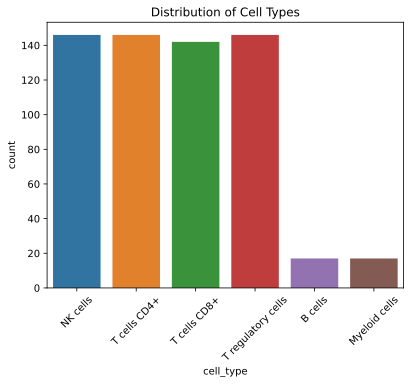

In [4]:
sns.countplot(data=df, x='cell_type')
plt.title('Distribution of Cell Types')
plt.xticks(rotation=45)
plt.show()

The dataset contains 6 cell types. **"B cells"** and **"Myeloid cells"** are underrepresented. 

In [5]:
df_control = df[df['control'] == True] 

print("Names of control drugs:", list(df_control["sm_name"].unique()))
print("Cells affected by control drugs:")
pd.DataFrame(df_control["cell_type"].value_counts())

Names of control drugs: ['Dabrafenib', 'Belinostat']
Cells affected by control drugs:


,count
cell_type,
B cells,2
Myeloid cells,2
NK cells,2
T cells CD4+,2
T cells CD8+,2
T regulatory cells,2


12 observations are from control group: 2 drugs for 6 cell types.  

In [6]:
print("Total number of drugs:", df["sm_name"].nunique())

Total number of drugs: 146


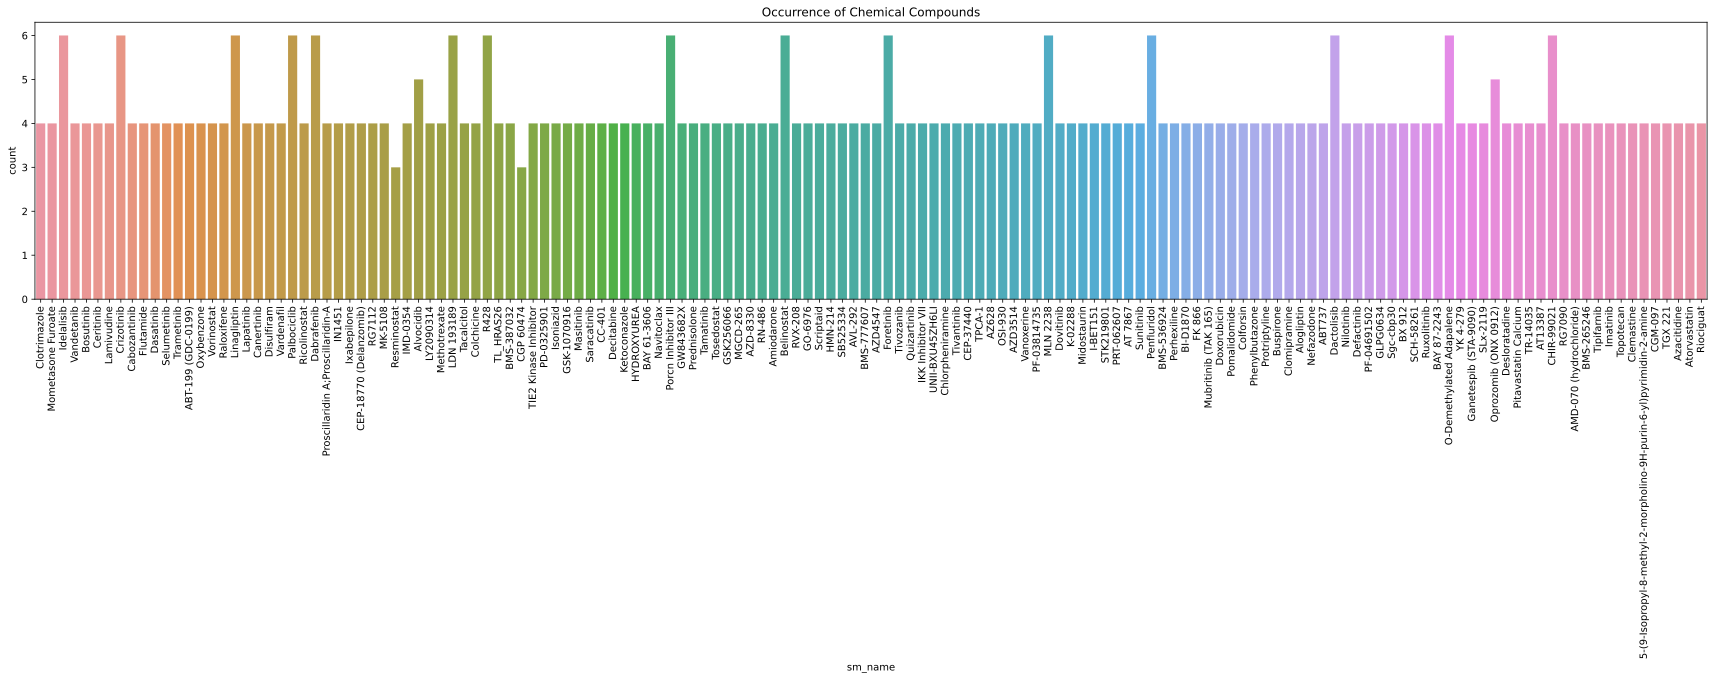

In [7]:
plt.figure(figsize=(30,5))
sns.countplot(data=df, x='sm_name')
plt.title('Occurrence of Chemical Compounds')
plt.xticks(rotation=90)
plt.show()

In [8]:
n_cells = df["cell_type"].nunique()
n_drugs = df["sm_name"].nunique()

print("Number of possible combinations of cell types and drugs: ", n_drugs*n_cells)

Number of possible combinations of cell types and drugs:  876


As we know from the competition's description, the results will be tested on the B cells and Myeloid cell data with chemical substances represented for other cell types.

*Have we the observations of the effect of 146 drugs for the rest 4 cell types?* No, because $146*4 + 17*2 = 618 $, but a number of observations is 614 (which is also seen from "Distribution of Cell Types" above ) 

In [9]:
for c in ["NK cells","T cells CD4+", "T cells CD8+", "T regulatory cells"] :
    for d in df["sm_name"].unique():
        if d not in df[df["cell_type"]==c]["sm_name"].to_list():
            print(f"Missed compound for {c} is {d}")

Missed compound for T cells CD8+ is Resminostat
Missed compound for T cells CD8+ is Alvocidib
Missed compound for T cells CD8+ is CGP 60474
Missed compound for T cells CD8+ is Oprozomib (ONX 0912)


In [10]:
for col in df.columns:
    if df[col].isnull().sum()>0:
        print(f"Found NaNs in {col}")

`de_train.parquet` doesn't contain NaNs. 

DE for a gene in the training dataset is Gaussian distributed with around zero mean.

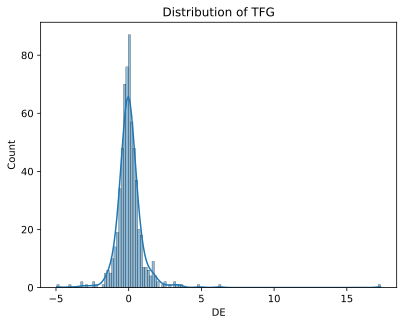

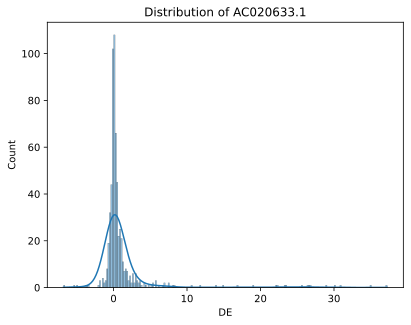

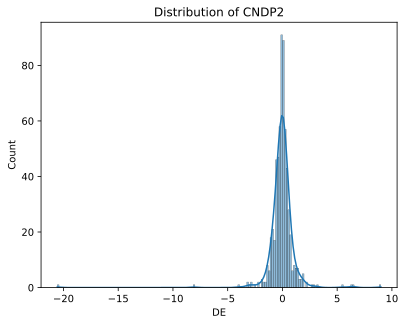

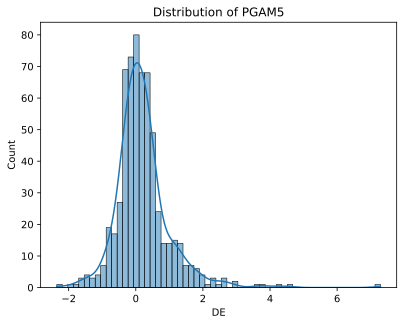

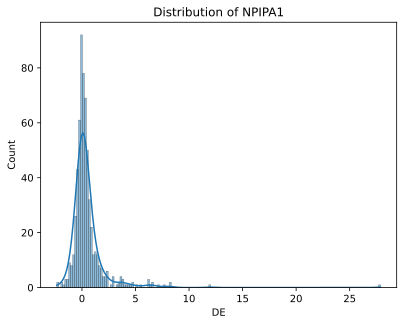

In [11]:
np.random.seed(seed=42)
random_genes = np.random.choice(list(df[target].columns), 5 )

for gene in random_genes:
    plt.figure()
    sns.histplot(data=df, x=gene, kde=True)
    plt.title(f'Distribution of {gene}')
    plt.xlabel("DE")
    plt.show()

DE distributions differ for different cell types:

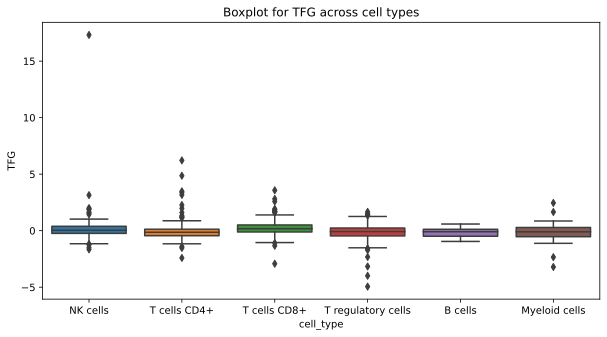

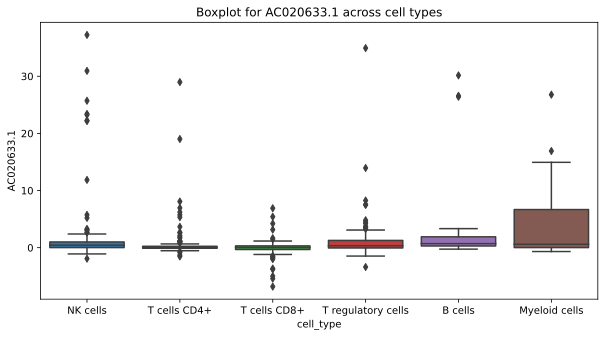

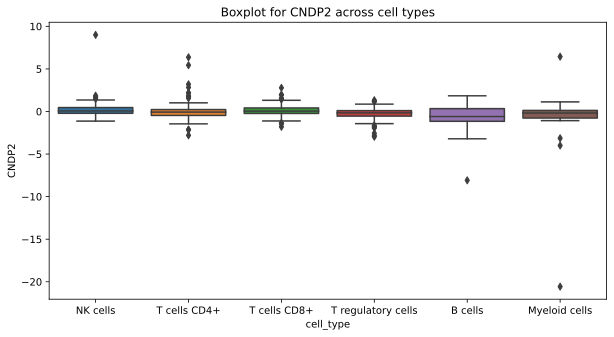

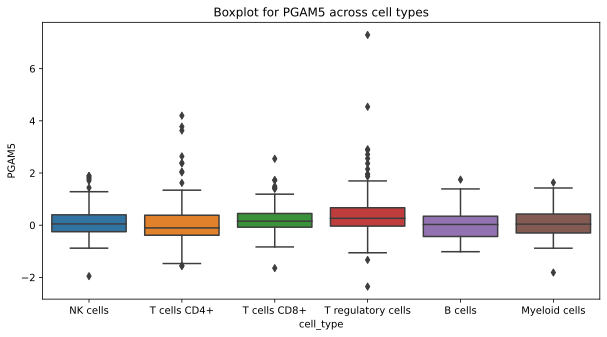

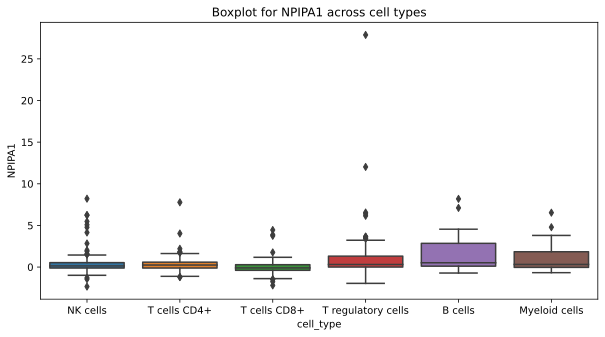

In [12]:
for gene in random_genes:
    plt.figure(figsize=(10,5))
    sns.boxplot(data=df, x='cell_type', y=gene)
    plt.title(f'Boxplot for {gene} across cell types')
    plt.show()

Below one can see the distributions of all genes for a specific subset of cells and chemical substances. Most of the distributions have a Gaussian form, but they can differ strongly, as was also noticed and described in [[1]](https://www.kaggle.com/code/ambrosm/scp-eda-which-makes-sense/notebook). 

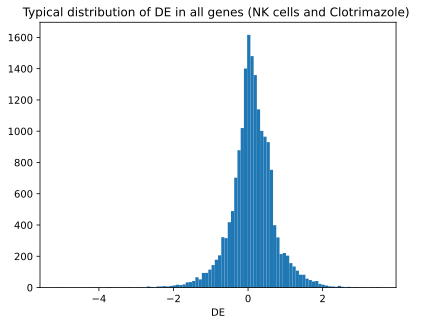

In [13]:
row_num = 0
cell = df.loc[row_num, ["cell_type", "sm_name"]].values[0]
drug = df.loc[row_num, ["cell_type", "sm_name"]].values[1]
plt.figure()
plt.hist(df.loc[row_num,target], bins=100)
plt.title(f"Typical distribution of DE in all genes ({cell} and {drug}) ")
plt.xlabel("DE")
plt.show()

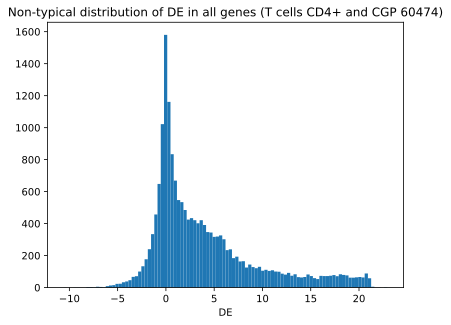

In [14]:
row_num = 183 
cell = df.loc[row_num, ["cell_type", "sm_name"]].values[0]
drug = df.loc[row_num, ["cell_type", "sm_name"]].values[1]
plt.figure()
plt.hist(df.loc[row_num,target], bins=100)
plt.title(f"Non-typical distribution of DE in all genes ({cell} and {drug})")
plt.xlabel("DE")
plt.show()

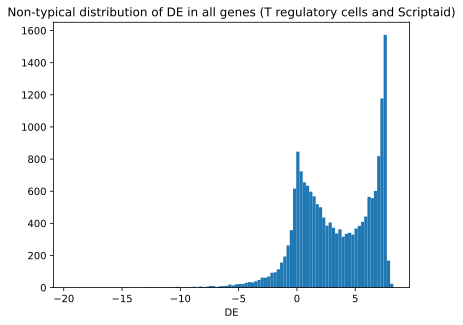

In [15]:
row_num = 292
cell = df.loc[row_num, ["cell_type", "sm_name"]].values[0]
drug = df.loc[row_num, ["cell_type", "sm_name"]].values[1]
plt.figure()
plt.hist(df.loc[row_num,target], bins=100)
plt.title(f"Non-typical distribution of DE in all genes ({cell} and {drug})")
plt.xlabel("DE")
plt.show()

In [16]:
print("Maximum value of DE:", round(df[target].max().max(),2))
print("Minimum value of DE:", round(df[target].min().min(),2))

Maximum value of DE: 179.32
Minimum value of DE: -180.52


As one can see above, usually gene distribution is Gaussian-like with a mean around zero. How does the distribution of genes with min/max DE look like?

It's shown below, that these extreme values are outliers.

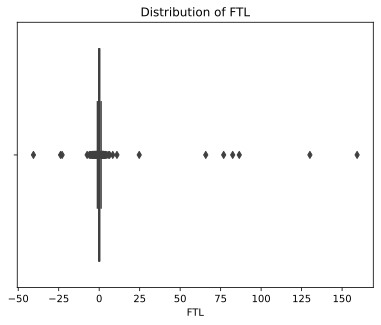

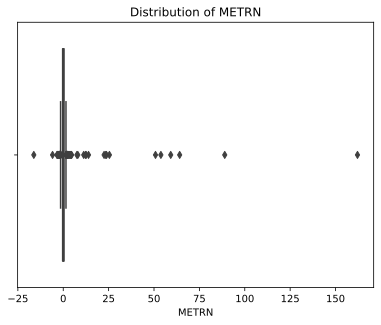

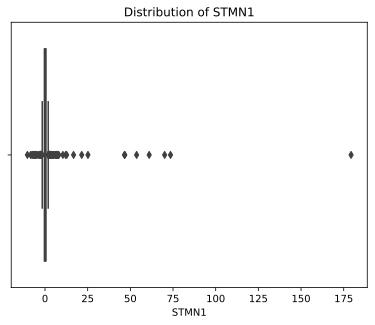

In [17]:
top_de_genes = df[target].max().sort_values()[-3:]

for gene in top_de_genes.index:
    plt.figure()
    sns.boxplot(data=df, x=gene)
    plt.title(f'Distribution of {gene}')
    plt.show()

Another look at the data, which will be used further, is a "signal" along rows or columns. It is a way to assess what exactly is going on with a model's prediction for the test data. 

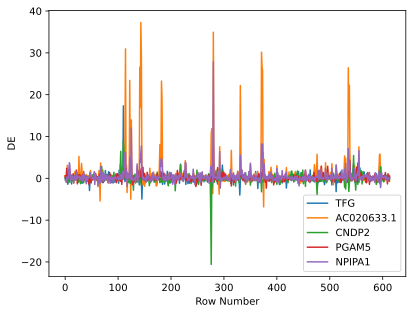

In [18]:
for g in random_genes:
    plt.plot(range(df.shape[0]), df.loc[:,g], label=g)
plt.xlabel("Row Number")
plt.ylabel("DE")
plt.legend()
plt.show()

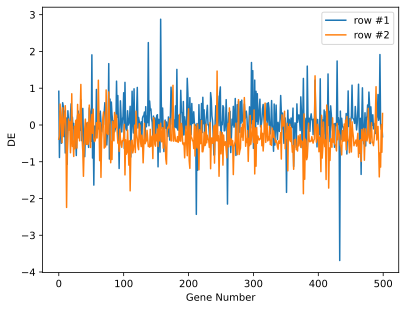

In [19]:
first_genes = 500
row_ind = 1

plt.plot(range(first_genes), df.loc[row_ind,target[:first_genes]], label=f"row #{row_ind}")
plt.plot(range(first_genes), df.loc[row_ind+1,target[:first_genes]], label=f"row #{row_ind+1}")
plt.xlabel("Gene Number")
plt.ylabel("DE")
plt.legend()
plt.show()

## Metric
Metric in this competition is Mean Rowwise Root Mean Squared Error, which is 

$$
MRRMSE=\frac{1}{R}\sum_{i=1}^R \left( \frac{1}{n} \sum_{j=1}^n (y_{ij} - \hat{y}_{ij})^2 \right)^{1/2}
$$


$R$ is the number of scored rows (number of observations), $n$ is the number of genes.

In [20]:
def metric(y, y_hat):
    """
    Calculates the Mean Row-wise Root Mean Squared Error (MR_RMSE) between two matrices.

    Args:
    - y (array-like): Ground truth matrix.
    - y_hat (array-like): Predicted matrix.

    Returns:
    float: Mean Row-wise Root Mean Squared Error (MR_RMSE) between y and y_hat.

    Raises:
    ValueError: If the input matrices y and y_hat do not have the same shape.

    """
    y = np.array(y)
    y_hat = np.array(y_hat)
    
    # Check if the input matrices have the same shape
    if y_hat.shape != y.shape:
        raise ValueError("Input matrices must have the same shape")

    # Calculate the squared differences element-wise
    squared_diff = (y - y_hat)**2

    # Calculate the mean row-wise RMSE
    rowwise_rmse = np.sqrt(np.mean(squared_diff, axis=1))

    # Calculate the mean of row-wise RMSE values
    mr_rmse = np.mean(rowwise_rmse, axis=0)
            
    return mr_rmse

Let's look at the behavior of the metric with Gaussian noise in the data.

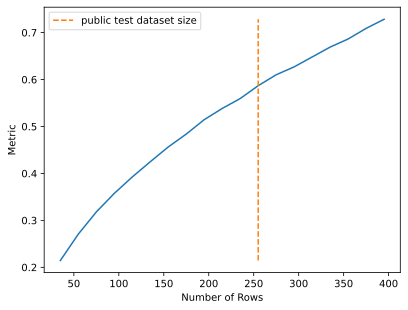

In [21]:
np.random.seed(42)

batch_sizes = range(35,400,20)
num_genes = len(target)

records = []

for size in batch_sizes: 
    rand_err_df = df[target].copy()
    for i in range(size):
        rand_err_df.loc[:i] -= 0.055* np.random.normal(size=num_genes)
        
    m = metric(df[target].loc[:size], rand_err_df.loc[:size] )
    records.append(m)
    
plt.plot(batch_sizes, records)
plt.plot([255,255], [min(records), max(records)], '--',label="public test dataset size")

plt.legend()
plt.xlabel("Number of Rows")
plt.ylabel("Metric")
plt.show()

The main contradiction between the metric and the competition's goal is that the dataset has a lot of outliers, but the metric is very sensitive to them by definition (for example, for 3 points from zero-mean  Gaussian distribution and 1 outlier the error $ RMSE = (0.99-0.98)^2 + (0.01-0.03)^2 + (170 - 168)^2 = 4.0005 $, which is mostly caused by the outlier). So it pushes any ML model to reward noise prediction instead of signal. Even if we clean the dataset, our prediction will be evaluated using the noisy test set. 

# Modelling 

## Build Baseline Models

To compare our model with something we need to create a heuristic (baseline) model. 

Because gene distributions are Gaussian-like with zero mean,  the first baseline model might be an array with zeros; here it is `prediction_0()`. 

For evaluating performance, we used a simple 6-fold cross-validation. 

In [22]:
def prediction_0(df_train, df_test):
    """
    Generates zero predictions for a given test dataset.

    Args:
    - df_train (pandas.DataFrame): Training dataset.
    - df_test (pandas.DataFrame): Test dataset.

    Returns:
    numpy.ndarray: Zero predictions for each sample in df_test.
    """
    
    y_pred = np.zeros((len(df_test), len(target)))
    
    return y_pred
    

def cross_validation(df, prediction=prediction_0, n_folds=6, print_folds=True):
    """
    Performs cross-validation on a given dataset using a specified prediction function.

    Args:
    - df (pandas.DataFrame): Dataset for cross-validation.
    - prediction (function): Prediction function to use during cross-validation.
    - n_folds (int): Number of folds for cross-validation.
    - print_folds (bool): If True, print MRRMSE for each fold.

    Returns:
    float: Mean of the MRRMSE values across all folds.
    """
    kfold = KFold(n_splits=n_folds,random_state=42, shuffle=True)

    metric_av = [] 
    counter = 0 

    for train, test in kfold.split(df):
        
        df_train = df.iloc[train]
        df_test = df.iloc[test]

        y_test = df_test[target]
        y_pred = prediction(df_train, df_test) 
        
        metric_av.append(metric(y_test,y_pred))
        
        if print_folds:
            print(f"Fold #{counter} MRRMSE:", round(metric(y_test,y_pred),4))
            counter +=1

    return round(np.mean(metric_av),4)

In [23]:
print("Baseline model #1 MRRMSE:", 
      cross_validation(df, prediction=prediction_0,print_folds=True)
     )

Fold #0 MRRMSE: 1.108
Fold #1 MRRMSE: 1.2657
Fold #2 MRRMSE: 1.4354
Fold #3 MRRMSE: 1.4458
Fold #4 MRRMSE: 1.2788
Fold #5 MRRMSE: 1.1568
Baseline model #1 MRRMSE: 1.2818


The second possible model might be an average over different drugs after denoising (compress the space with 18211 genes and decompress it back). 



In [24]:
def tsvd_inv_drug_av(df_train, df_test, reducer):
    """
    Applies dimensionality reduction and inverse transform to denoise a dataset,
    aggregates drug information, and predicts target values for a test dataset.
    The idea is from  https://www.kaggle.com/code/alexandervc/op2-eda-baseline-s 

    Args:
    - df_train (pandas.DataFrame): Training dataset.
    - df_test (pandas.DataFrame): Test dataset.
    - reducer: Dimensionality reduction model with 'transform' and 'inverse_transform' methods.

    Returns:
    pandas.Series: Predicted target values for the test dataset.
    """
    n_components = 36
    quantile = 0.54
    aggr_feature = "sm_name"

    X = df[target] 

    # Apply dimensionality reduction and inverse transform to denoise the dataset
    Xr = reducer.transform(X)
    Xr_inv_trans = reducer.inverse_transform(Xr)

    # Create a DataFrame with denoised data and original categorical feature
    df_denoised = pd.DataFrame(Xr_inv_trans, columns=target)
    df_denoised[aggr_feature] = df[aggr_feature]

    # Aggregate drug information using quantile and group by the specified feature
    df_drug_aggr = df_denoised.groupby(aggr_feature).quantile(quantile)

    # Merge aggregated drug information with test dataset to get predictions
    y_pred = df_test[features].merge(df_drug_aggr, how='left', on=aggr_feature)[target]
    
    return y_pred

In [25]:
def cross_validation_reduced(df, prediction=prediction_0, n_folds=6,  print_folds=True):
    """
    Performs cross-validation with dimensionality reduction on a given dataset.

    Args:
    - df (pandas.DataFrame): Dataset for cross-validation.
    - prediction (function): Prediction function to use during cross-validation.
    - n_folds (int): Number of folds for cross-validation.
    - print_folds (bool): If True, print MRRMSE for each fold.

    Returns:
    float: Mean of the MRRMSE values across all folds.
    """
    n_components = 36 
    kfold = KFold(n_splits=n_folds,random_state=42, shuffle=True)
    reducer = TruncatedSVD(n_components=n_components,  n_iter=7, random_state=42) 
    
    reducer.fit(df[target])

    metric_av = [] 
    counter = 0 

    for train, test in kfold.split(df):
        
        df_train = df.iloc[train]
        df_test = df.iloc[test]
        
        # To be fully honest, we need to train reducer only over df_train, like 
        # reducer.fit(df_train[target])
        # but in this case we overestimate the error 
        # (make the test on compounds that were not in train data, which is not the case 
        # for both public and private evaluation of the model)
        
        y_pred = prediction(df_train, df_test, reducer)
        y_test = df_test[target]
        
        metric_av.append(metric(y_test,y_pred))
        
        if print_folds:
            print(f"Fold #{counter} MRRMSE:", round(metric(y_test,y_pred),4))
            counter +=1

    return round(np.mean(metric_av),4)

In [26]:
print("Model #2 MRRMSE:", 
      cross_validation_reduced(df, prediction=tsvd_inv_drug_av, print_folds=True)
     )

Fold #0 MRRMSE: 0.9135
Fold #1 MRRMSE: 1.1125
Fold #2 MRRMSE: 1.2416
Fold #3 MRRMSE: 1.1819
Fold #4 MRRMSE: 1.0716
Fold #5 MRRMSE: 0.9351
Model #2 MRRMSE: 1.076


The third model is the average value of compressed DE  for each drug (prediction is the same for all cell types). 

In [27]:
def tsvd_drug_av_inv(df_train, df_test, reducer):
    """
    Applies dimensionality reduction to a dataset, computes the average of each drug's reduced representation,
    inversely transforms the averaged representation, and predicts target values for a test dataset.

    Args:
    - df_train (pandas.DataFrame): Training dataset.
    - df_test (pandas.DataFrame): Test dataset.
    - reducer: Dimensionality reduction model with 'transform' and 'inverse_transform' methods.

    Returns:
    pandas.Series: Predicted target values for the test dataset.
    """
    X = df[target] 
    aggr_feature = "sm_name"
    
    # Apply dimensionality reduction
    Xr = reducer.transform(X)
    
    n_components = Xr.shape[1]
    
    # Get unique drugs from the dataset
    drugs = df[aggr_feature].unique()
    
    # Initialize an array to store the average representation for each drug
    X_av_drug = np.zeros((len(drugs), n_components))
    
    # Create a DataFrame to store averaged drug representations
    df_ = pd.DataFrame(columns=[aggr_feature] + target)
    df_[aggr_feature] = drugs
    
    # Compute the average representation for each drug
    for i, d in enumerate(drugs):
        observations = df[df[aggr_feature] == d].index.to_list()
        X_av_drug[i, :] = np.mean(Xr[observations, :], axis=0)

    # Inversely transform the averaged drug representations
    X_av_drug_inv = reducer.inverse_transform(X_av_drug)
    
    # Update the DataFrame with the averaged and inversely transformed drug representations
    df_[target] = X_av_drug_inv.copy()
    
    # Merge averaged drug representations with the test dataset to get predictions
    y_pred = df_test[features].merge(df_, how='left', on=aggr_feature)[target]
    
    return y_pred

In [28]:
print("Model #3 MRRMSE:", 
      cross_validation_reduced(df, prediction=tsvd_drug_av_inv, print_folds=True)
     )

Fold #0 MRRMSE: 0.92
Fold #1 MRRMSE: 1.1164
Fold #2 MRRMSE: 1.1913
Fold #3 MRRMSE: 1.2195
Fold #4 MRRMSE: 1.0516
Fold #5 MRRMSE: 0.9312
Model #3 MRRMSE: 1.0717


## XGBoost Demo

To illustrate the logic of the approach, we provide detailed annotated code.

In [29]:
# Set the number of components for TruncatedSVD
n_components = 36

# Initialize TruncatedSVD with specified parameters
reducer = TruncatedSVD(n_components=n_components, n_iter=7, random_state=42) #20 and 7 are best

# Initialize Target Encoder with smoothing parameter
enc = ce.TargetEncoder(smoothing=8) 
    
X = df[target] 

aggr_feature = "sm_name"

Xr = reducer.fit_transform(X)

# Get unique values for 'sm_name' and 'cell_type'
drugs = list(df[aggr_feature].unique())  
cells = list(df["cell_type"].unique())

# Create names for the zip (after TruncatedSVD) and one-hot encoded columns
zip_names = [i for i in range(n_components)]


# Initialize DataFrames to store zip-encoded features and TruncatedSVD components
X_zip = pd.DataFrame(np.zeros((len(df),len(zip_names))),
                            columns = zip_names)

y_zip = pd.DataFrame(Xr)


# Initialize an index variable to fill the DataFrame with features
ind = 0
for i,d in enumerate(drugs):
    
    # Create a copy of the dataframe for the current drug
    df_one_drug = df[df[aggr_feature]==d].copy() 
    observations = df_one_drug.index.to_list()
    
    # Get unique cell types for the current drug
    cells_ = list(df_one_drug["cell_type"].unique())
    
    for j,c in enumerate(cells_):
        
        # Set one-hot encoded values for drug and cell type
        X_zip.loc[ind, d] = 1 
        X_zip.loc[ind, [k for k in cells_ if k!= c]] = 1
        
        # Get the indexes of the rest of the cell types
        # cell_index = df_one_drug[df_one_drug["cell_type"] == c].index.to_list()
        rest_indexes = df_one_drug[df_one_drug["cell_type"] != c].index.to_list()
        
        # Get the features as the mean of TruncatedSVD components for the rest of the cell types
        X_zip.loc[ind, zip_names] = np.mean(Xr[rest_indexes,:], axis=0)

        ind+=1
        
        

In [30]:
X_categ = df[features]

# Initialize an array to store encoded categorical features based on TruncatedSVD components
X_categ_trained = np.zeros((len(df),2*n_components))

# Loop through each TruncatedSVD component
for n in range(n_components):
    # Fit Target Encoder on the categorical features using the current TruncatedSVD component
    cat_encoding_one_component = enc.fit_transform(X_categ, Xr[:,n])
    
    # Assign the encoded values to the corresponding columns 
    X_categ_trained[:,2*n] = cat_encoding_one_component["cell_type"]
    X_categ_trained[:,2*n+1] = cat_encoding_one_component["sm_name"]

# Create a DataFrame from the encoded categorical features
X_categ_ = pd.DataFrame(X_categ_trained, columns=[f"c_{i}" for i in range(2*n_components)])

# Concatenate the aggregated by drug features and the encoded categorical features
X_zip_ = pd.concat([X_zip, X_categ_], axis=1)

X_zip_ 

,0,1,2,3,4,5,6,7,8,9,...,c_62,c_63,c_64,c_65,c_66,c_67,c_68,c_69,c_70,c_71
0,10.084822,4.540404,-1.606050,-0.632172,1.838400,3.217693,-1.986014,-2.711262,-0.343424,-2.128824,...,2.888913,0.623729,0.727538,2.397627,0.882119,-0.371293,-1.290598,-1.145563,11.178856,1.791370
1,16.614434,2.738527,-1.645047,-0.665975,0.883785,2.790618,-0.661639,-1.978878,-0.529411,-2.126063,...,-4.143417,0.623729,2.216320,2.397627,-2.692849,-0.371293,-1.754537,-1.145563,-7.031578,1.791370
2,31.667649,3.365358,-0.871207,-2.053638,2.504077,4.811603,-0.751740,-2.397813,-0.136584,-3.188285,...,1.484317,0.623729,2.469432,2.397627,0.195533,-0.371293,-0.160393,-1.145563,1.912436,1.791370
3,0.824943,6.233855,-2.873033,1.923814,-5.332376,3.384821,-1.979642,-2.791548,-0.114509,-4.481561,...,2.188865,0.623729,3.414401,2.397627,-0.276125,-0.371293,-1.230123,-1.145563,0.757383,1.791370
4,53.436544,15.259723,5.831637,-7.348379,13.452737,25.431441,-5.712426,3.698131,-0.648230,-34.563451,...,2.888913,1.210741,0.727538,2.277269,0.882119,-0.431561,-1.290598,-0.674985,11.178856,1.887332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,9.431194,-1.640770,0.730905,1.453525,-0.039008,5.327922,-0.518421,-0.064691,0.028496,-2.860619,...,2.188865,0.981124,3.414401,2.260782,-0.276125,-0.712703,-1.230123,-1.565638,0.757383,1.575023
610,-41.556912,7.410138,-2.553605,5.564109,-12.756988,1.382872,-2.936656,-1.582632,0.971542,-1.456593,...,2.888913,0.911401,0.727538,2.364920,0.882119,-0.651275,-1.290598,-1.402357,11.178856,1.447628
611,-34.891774,5.347746,-2.299946,5.841082,-13.294984,1.610162,-1.914495,-1.404936,0.162467,-3.584520,...,-4.143417,0.911401,2.216320,2.364920,-2.692849,-0.651275,-1.754537,-1.402357,-7.031578,1.447628
612,-18.938215,4.993432,-1.336409,2.831809,-9.517867,1.671122,-1.620482,-1.235878,0.757467,-3.573144,...,1.484317,0.911401,2.469432,2.364920,0.195533,-0.651275,-0.160393,-1.402357,1.912436,1.447628


In [31]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X_zip_, y_zip, test_size=0.15, random_state=22 
)

In [32]:
params = {
'tree_method': 'hist',
'eval_metric': 'rmse',
'max_depth': 2, 
'learning_rate': 0.2,
'silent': 1.0,      
'n_estimators': 500,
'random_state': 42}

xgb_regressor = xgb.XGBRegressor(**params)


xgb_regressor.fit(X_train,y_train) 

y_pred = xgb_regressor.predict(X_test)

y_pred = pd.DataFrame(y_pred, index=X_test.index)

Display a single observation for average by drugs, xgboost predictions, and test compressed data 

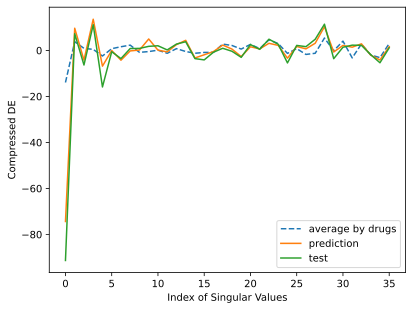

In [33]:
j = 6
j_ = X_test.index[j]

plt.plot(zip_names, X_test.loc[j_,zip_names],'--', label="average by drugs")
plt.plot(zip_names, y_pred.loc[j_], label="prediction")
plt.plot(zip_names, y_test.loc[j_] , label="test")
plt.xlabel("Index of Singular Values")
plt.ylabel("Compressed DE")

plt.legend()
plt.show()

Display values of a single component for average by drugs, xgboost predictions, and test compressed data. 

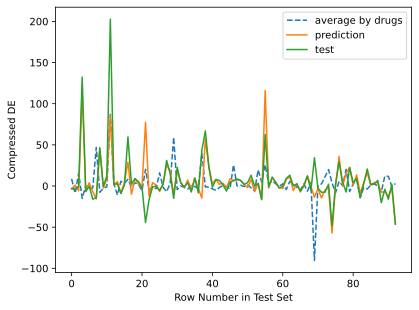

In [34]:
j = 4

plt.plot(range(len(X_test)), X_test[j],'--', label="average by drugs")
plt.plot(range(len(X_test)), y_pred[j], label="prediction")
plt.plot(range(len(X_test)), y_test[j] , label="test")
plt.xlabel("Row Number in Test Set")
plt.ylabel("Compressed DE")
plt.legend()
plt.show()

Test for the decompressed result.

In [35]:

Y_pred = pd.DataFrame(reducer.inverse_transform(y_pred), columns=target, index=X_test.index)

Y_test = df.loc[y_test.index, target]

print("MRRMSE:", round(metric(Y_test, Y_pred),4))

MRRMSE: 0.9387


Display a single observation for xgboost prediction and test data (first 200 genes)


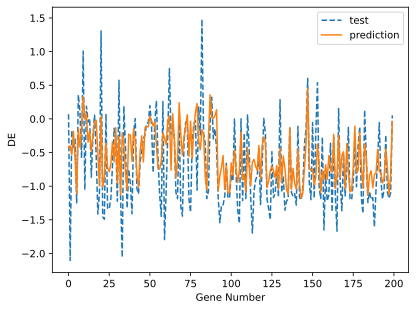

In [36]:
j = 6
j_ = X_test.index[j]

plt.plot(range(200), Y_test.loc[j_,target[:200]],'--', label="test")
plt.plot(range(200), Y_pred.loc[j_,target[:200]], label="prediction")
plt.xlabel("Gene Number")
plt.ylabel("DE")

plt.legend()
plt.show()

 Display values of a single gene for xgboost prediction and test data

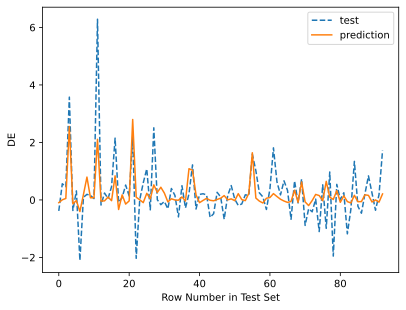

In [37]:
g = 1

plt.plot(range(len(Y_test)), Y_test.loc[:,target[g]],'--', label="test")
plt.plot(range(len(Y_test)), Y_pred.loc[:, target[g]], label="prediction")
plt.xlabel("Row Number in Test Set")
plt.ylabel("DE")

plt.legend()
plt.show()

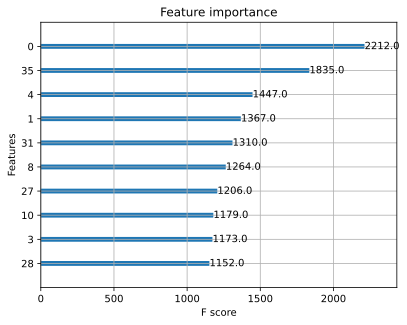

In [38]:
xgb.plot_importance(xgb_regressor, max_num_features=10); # top 10 most important features

### Comparison with the average drugs prediction in the compressed space

In [39]:
df_train = df.iloc[X_train.index]
df_test = df.iloc[X_test.index]

y_pred_av = tsvd_drug_av_inv(df_train,df_test, reducer)

print("MRRMSE:", metric(Y_test, y_pred_av))

MRRMSE: 1.066765409833509


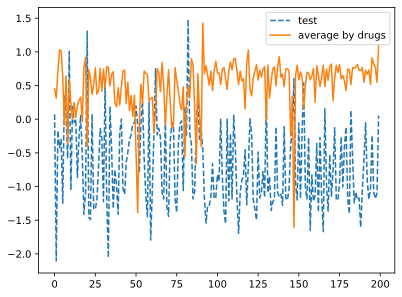

In [40]:
j = 6
j_ = X_test.index[j]

plt.plot(range(200), Y_test.loc[j_,target[:200]],'--', label="test")
plt.plot(range(200), y_pred_av.loc[j_,target[:200]], label="average by drugs")

plt.legend()
plt.show()

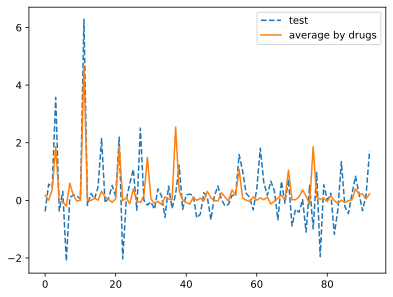

In [41]:
g = 1

plt.plot(range(len(Y_test)), Y_test.loc[:,target[g]],'--', label="test")
plt.plot(range(len(Y_test)), y_pred_av.loc[:, target[g]], label="average by drugs")

plt.legend()
plt.show()

## XGBoost Training

To summarize your approach, we provide the cross-validation and related functions of it below.
We also added one-hot encoding because it gives better CV, public, and private scores.

In [42]:
# from https://www.kaggle.com/code/ambrosm/scp-eda-which-makes-sense
def de_to_t_score(de):
    """Convert log10pvalues to t-scores
    
    Parameter:
    de: array or DataFrame of log10pvalues
    
    Return value:
    t_score: array or DataFrame of t-scores
    """
    p_value = 10 ** (-np.abs(de))
    return - scipy.stats.t.ppf(p_value / 2, df=420) * np.sign(de)
#     return - norm.ppf(p_value / 2) * np.sign(de)


# from https://www.kaggle.com/code/ambrosm/scp-eda-which-makes-sense
def t_score_to_de(t_score):
    """Convert t-scores to log10pvalues (inverse of de_to_t_score)
    
    Parameter:
    t_score: array or DataFrame of t-scores
    
    Return value:
    de: array or DataFrame of log10pvalues
    """
    p_value = scipy.stats.t.cdf(- np.abs(t_score), df=420) * 2
#     p_value = norm.cdf(- np.abs(t_score)) * 2
    p_value = p_value.clip(1e-180, None)
    return - np.log10(p_value) * np.sign(t_score)


def obtain_reduced_data(df, reducer, encoder, t_score = False):
    
    """
    Obtains reduced data for a given DataFrame using dimensionality reduction and encoding techniques.

    Args:
        df (pd.DataFrame): Input DataFrame containing the data.
        reducer: An instance of a dimensionality reduction model.
        encoder: An instance of an encoding model for categorical features.

    Returns:
        pd.DataFrame: Reduced and encoded feature matrix.
        pd.DataFrame: Original reduced feature matrix.
    """
    
    # Extracting the target variable for dimensionality reduction
    if t_score:
        X = de_to_t_score(df[target])
    else: 
        X = df[target] 

    # Defining the aggregation feature for grouping
    aggr_feature = "sm_name"
    
    # Transforming the data using the provided dimensionality reduction technique
    Xr = reducer.transform(X)
    
    # Extracting the number of components after dimensionality reduction
    n_components = Xr.shape[1]
    
    # Extracting unique drug and cell type names
    drugs = list(df[aggr_feature].unique())
    cells = list(df["cell_type"].unique())
    
    one_hot_names = drugs + cells 
    
    # Creating names for zip columns
    zip_names = [i for i in range(n_components)]

    X_zip = pd.DataFrame(np.zeros((len(df),len(one_hot_names)+len(zip_names))),
                                columns = one_hot_names + zip_names)
    
    # Initializing DataFrames for the reduced and encoded features
    y_zip = pd.DataFrame(Xr)
    
    # Looping through drugs and cells to calculate the mean of the cell types for 
    # each drug in compressed space
    ind = 0
    for i,d in enumerate(drugs):

        df_one_drug = df[df[aggr_feature]==d].copy()
        observations = df_one_drug.index.to_list()

        cells_ = list(df_one_drug["cell_type"].unique())

        for j,c in enumerate(cells_):
            
            X_zip.loc[ind, d] = 1 
            X_zip.loc[ind, [k for k in cells_ if k!= c]] = 1
   
            rest_indexes = df_one_drug[df_one_drug["cell_type"] != c].index.to_list()

            X_zip.loc[ind, zip_names] = np.mean(Xr[rest_indexes,:], axis=0)

            ind+=1
            
    # Extracting categorical features for encoding
    X_categ = df[features]
    
    # Initializing the array for the encoded categorical features
    X_categ_trained = np.zeros((len(df),2*n_components))
    
    # Looping through components for encoding categorical features
    for n in range(n_components):

        cat_encoding_one_component = encoder.fit_transform(X_categ, Xr[:,n])

        X_categ_trained[:,2*n] = cat_encoding_one_component["cell_type"]
        X_categ_trained[:,2*n+1] = cat_encoding_one_component["sm_name"]
    
    # Concatenating the reduced and encoded features into a single DataFrame
    X_zip_ = pd.concat([X_zip ,pd.DataFrame(X_categ_trained, columns=[f"c_{i}" for i in range(2*n_components)])], axis=1)
        
    return X_zip_, y_zip
    
def xgb_prediction(X_train, y_train, X_test, reducer):
    """
    Perform XGBoost regression for dimensionality-reduced data.

    Args:
        X_train (pd.DataFrame): Training data features.
        y_train (pd.Series): Training data labels.
        X_test (pd.DataFrame): Test data features.
        reducer: An instance of a dimensionality reduction model.
    Note:
        The function uses XGBoost to predict values in the original feature space
        for the given test data, assuming dimensionality reduction has been applied
        using the provided reducer.
    """
    
    params = {
            'tree_method': 'hist',
            'eval_metric': 'rmse',
            'max_depth': 2, 
            'learning_rate': 0.2,
            'silent': 1.0,      
            'n_estimators': 1000,
            'random_state': 42}

    xgb_regressor = xgb.XGBRegressor(**params)

    xgb_regressor.fit(X_train,y_train) 
    y_pred = xgb_regressor.predict(X_test)
    
    Y_pred = pd.DataFrame(reducer.inverse_transform(y_pred), columns=target, index=X_test.index)

    return Y_pred

def cross_validation_xgb(df, prediction=xgb_prediction, n_folds=6, n_components = 36, print_folds=True, t_score=False):
    """
    Perform cross-validation using XGBoost with dimensionality reduction.

    Args:
    - df (pd.DataFrame): The input DataFrame containing features and target variable.
    - prediction (function): The prediction function (default is xgb_prediction).
    - n_folds (int): Number of folds for cross-validation (default is 6).
    - n_components (int): Number of components for dimensionality reduction (default is 36).
    - print_folds (bool): Flag to print fold-wise results (default is True).

    Returns:
    - float: Mean metric value across all folds.
    """
    # Set up KFold for cross-validation    
    kfold = KFold(n_splits=n_folds,random_state=42, shuffle=True)
    
    # Dimensionality reduction using TruncatedSVD
    reducer = TruncatedSVD(n_components=n_components, n_iter=7, random_state=42) #20 and 7 are the best on CV
    
    # Target encoding using TargetEncoder
    encoder = ce.TargetEncoder(smoothing=8) # 8 and 12 
    
    # Extract target variables (genes) from the DataFrame
    if t_score:
        X = de_to_t_score(df[target]) 
    else:
        X = df[target] 
    
    # Fit reducer on the target variables
    reducer.fit(X)
    
    # Obtain reduced data using dimensionality reduction and target encoding
    X_zip, y_zip = obtain_reduced_data(df, reducer, encoder, t_score=t_score)

    # Initialize lists for storing metric values and a counter for fold number
    metric_av = [] 
    counter = 0 
    
    # Loop through each fold in KFold
    for train, test in kfold.split(X_zip):
        # Split data into training and testing sets
        X_train_fold = X_zip.iloc[train] 
        y_train_fold = y_zip.iloc[train]
        
        X_test_fold = X_zip.iloc[test]
        y_test_fold = df[target].iloc[test].copy()
        
        # Make predictions using the specified prediction function
        y_pred = prediction(X_train_fold, y_train_fold, X_test_fold, reducer)
        
        if t_score:
            y_pred = t_score_to_de(y_pred)
            
        # Calculate and store the metric value for the fold
        metric_av.append(metric(y_test_fold,y_pred))
        
        # Print fold-wise results if specified
        if print_folds:
            print(f"Fold #{counter} MRRMSE:", round(metric(y_test_fold,y_pred),4))
            counter +=1
    # Return the mean of the metric values across all folds
    return round(np.mean(metric_av),4)

In [43]:
print("XGB Model MRRMSE:", 
      cross_validation_xgb(df,  print_folds=True)
  )

Fold #0 MRRMSE: 0.8546
Fold #1 MRRMSE: 1.0438
Fold #2 MRRMSE: 1.0607
Fold #3 MRRMSE: 1.1164
Fold #4 MRRMSE: 1.0357
Fold #5 MRRMSE: 0.8519
XGB Model MRRMSE: 0.9939


*Is it better to use a t-score instead of DE for our model? [1]*. It gives a better score on CV, but worse on the public and private test. 

### Cell type validation 

Does the accuracy of our model depend on cell types in the dataset? To answer this, we compute the metric for cell types excluding one of 4 cell types from the training set ("NK cells", "T cells CD4+", "T cells CD8+", "T regulatory cells"). The score for **T cells CD8+** should be a little bit lower than the ground truth, because we have only 142 observations instead of 146 (see above). 


In [44]:
def validate_cells(df, prediction=xgb_prediction, n_components = 36, print_folds=True):
    """
    Perform cross-validation of a model using for training dataset without one cell type from a list
    ["NK cells", "T cells CD4+", "T cells CD8+", "T regulatory cells"]

    Args:
    - df (pd.DataFrame): The input DataFrame containing features and target variable.
    - prediction (function): The prediction function (default is xgb_prediction).
    - n_components (int): Number of components for dimensionality reduction (default is 36).
    - print_folds (bool): Flag to print fold-wise results (default is True).

    Returns:
    - float: Mean metric value across all folds.
    """
    # Set up KFold for cross-validation    
    kfold = KFold(n_splits=5,random_state=42, shuffle=True)
    
    # Dimensionality reduction using TruncatedSVD
    reducer = TruncatedSVD(n_components=n_components, n_iter=7, random_state=42) #20 and 7 are the best on CV
    
    # Target encoding using TargetEncoder
    encoder = ce.TargetEncoder(smoothing=8) # 8 and 12 
    
    # Extract target variables (genes) from the DataFrame
    X = df[target] 
    
    cell_types = ["NK cells", "T cells CD4+", "T cells CD8+", "T regulatory cells"]
    
    cell_exclude_indexes = [ df[df["cell_type"] == c].index.to_list() for c in cell_types ]
    
    # Fit reducer on the target variables
    reducer.fit(X)
    
    # Obtain reduced data using dimensionality reduction and target encoding
    X_zip, y_zip = obtain_reduced_data(df, reducer, encoder)

    # Initialize lists for storing metric values and a counter for fold number
    metric_av = [] 
    
    counter = 0
    
    for c in cell_exclude_indexes:
        
        metric_cell_av = []
        X_exclude_cell = X_zip.drop(c)
        
        for train, test in kfold.split(X_exclude_cell):
            # Split data into training and testing sets
            X_train_fold = X_zip.iloc[train] 
            y_train_fold = y_zip.iloc[train]

            X_test_fold = X_zip.iloc[test]
            y_test_fold = df[target].iloc[test].copy()

            # Make predictions using the specified prediction function
            y_pred = prediction(X_train_fold, y_train_fold, X_test_fold, reducer)

            # Calculate and store the metric value for the fold
            metric_cell_av.append(metric(y_test_fold,y_pred))
        
        metric_av.append(np.mean(metric_cell_av))

        # Print fold-wise results if specified
            
        if print_folds:
            print(f"{cell_types[counter]} excluded MRRMSE:", round(metric_av[counter],4))
            counter +=1
            
    # Return the mean of the metric values across all cells
    return round(np.mean(metric_av),4)

In [45]:
print("XGB Model MRRMSE:", 
      validate_cells(df,  print_folds=True)
  )

NK cells excluded MRRMSE: 1.0881
T cells CD4+ excluded MRRMSE: 1.0881
T cells CD8+ excluded MRRMSE: 1.0922
T regulatory cells excluded MRRMSE: 1.0881
XGB Model MRRMSE: 1.0891


Notably, the accuracy of the model differs only at T cells CD8+ exclusion, and not significantly. We believe that it happens because our prediction is based on the average of cell types in compressed space, therefore training on data with more cell types gives a better prediction. 

# Submission

In [46]:
def drug_av_zip(df, idtab, reducer, encoder, t_score=False):
    """
    Create a feature encoding, applying a drug-specific averaging in compressed space to a given dataframe.

    Parameters:
    - df (pd.DataFrame): Input training dataframe.
    - idtab (pd.DataFrame): Reference dataframe for encoding features.
    - reducer: A dimensionality reduction model used for compression.

    Returns:
    pd.DataFrame: A new dataframe containing feature encoding.
    """
    
    # Extracting the target variable for dimensionality reduction
    if t_score:
        X = de_to_t_score(df[target])
    else:
        X = df[target] 
    
    # Defining the aggregation feature for grouping
    arrg_feature = "sm_name"
    
    # Transforming the data using the provided dimensionality reduction technique
    Xr = reducer.transform(X)
    
    # Extracting the number of components after dimensionality reduction
    n_components = Xr.shape[1]
    
    # Extracting unique drug names
    drugs = list(df[arrg_feature].unique())
    
    X_av_drug = np.zeros((len(drugs), n_components))
    
    # Creating names for zip columns
    zip_names = [i for i in range(n_components)]
    
    df_ = pd.DataFrame( columns= [arrg_feature] + zip_names)
    
    df_[arrg_feature] = drugs
    
    # Looping through drugs to compute the mean of the cell types for 
    # each drug in compressed space
    
    for i,d in enumerate(drugs):
        observations = df[df[arrg_feature]==d].index.to_list()
    
        X_av_drug[i,:] =  np.mean(Xr[observations,:], axis=0)

        
    df_[zip_names] =  X_av_drug.copy()
    
    X_zip = idtab[features].merge(df_, how='left', on="sm_name")
            
    #---------- categorical features encoding --------------------------#
    X_categ = idtab[features]

    X_categ_trained = np.zeros((len(idtab),2*n_components))
    
    # Looping through components for encoding categorical features
    for n in range(n_components):

        enc.fit(df[features], Xr[:,n])

        cat_encoding_one_component = enc.transform(X_categ, X_zip[n])

        X_categ_trained[:,2*n] = cat_encoding_one_component["cell_type"]
        X_categ_trained[:,2*n+1] = cat_encoding_one_component["sm_name"]

     # Concatenating the reduced and encoded features into a single DataFrame
    X_zip_ =  pd.concat([X_zip, pd.DataFrame(X_categ_trained,  columns=[f"c_{i}" for i in range(2*n_components)])], axis=1) 
    
    one_hot_names = drugs + cells
    
    # This loop iterates over each element in one_hot_names and inserts a new 
    # column with that name filled with zeros into the DataFrame X_zip_. 
    # The "+2" in the insert function suggests that the new columns are inserted 
    # starting from the third column.
    for i in range(len(one_hot_names)):
        X_zip_.insert(i+2, one_hot_names[i], np.zeros(X_zip_.shape[0]))
        
    # One-Hot Encoding for Drugs and Cell Types
    
    # It then sets the value in the DataFrame at the intersection of the current
    # row and the column with the name d to 1, indicating the presence of that drug.
    # Similarly, it sets the values in columns corresponding to cell types not equal 
    # to c for the same drug d to 1, indicating the presence of that drug for those other cell types.
    for ind in X_zip_.index:
        d = X_zip_.loc[ind, "sm_name"]
        X_zip_.loc[ind, d] = 1 
        
        c = X_zip_.loc[ind, "cell_type"]
        
        cells_in_train = df[(df["cell_type"]!=c) & (df["sm_name"]==d)]["cell_type"]
        X_zip_.loc[ind, cells_in_train] = 1 
        
    X_zip_.drop(columns=features, inplace=True)
    
    return X_zip_

In [47]:
fn = '/kaggle/input/open-problems-single-cell-perturbations/id_map.csv'
df_id_map = pd.read_csv(fn)

df_id_map

,id,cell_type,sm_name
0,0,B cells,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...
1,1,B cells,ABT-199 (GDC-0199)
2,2,B cells,ABT737
3,3,B cells,AMD-070 (hydrochloride)
4,4,B cells,AT 7867
...,...,...,...
250,250,Myeloid cells,Vandetanib
251,251,Myeloid cells,Vanoxerine
252,252,Myeloid cells,Vardenafil
253,253,Myeloid cells,Vorinostat


In [48]:
n_components = 36
reducer = TruncatedSVD(n_components=n_components, n_iter=7, random_state=42)
encoder = ce.TargetEncoder(smoothing=8)
t_score = False

if t_score:
    X = de_to_t_score(df[target])
else: 
    X = df[target] 

reducer.fit(X)

X_test = drug_av_zip(df, df_id_map, reducer, encoder, t_score=t_score)

X_zip, y_zip = obtain_reduced_data(df, reducer, encoder, t_score=t_score)
 

In [49]:
%%time

Y_pred = xgb_prediction(X_zip, y_zip, X_test, reducer) 

if t_score:
    Y_pred = t_score_to_de(Y_pred)

CPU times: user 4min 1s, sys: 1.25 s, total: 4min 2s
Wall time: 1min 2s


In [50]:
Y_pred.index.name = 'id'
Y_pred

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
id,,,,,,,,,,,,,,,,,,,,,
0,0.679848,0.333028,0.956681,1.091768,1.648320,1.448786,-0.034437,0.632100,-0.226602,0.618665,...,-0.238299,0.162006,0.276826,0.291006,0.776852,0.557041,0.613252,0.520925,-0.320521,0.213927
1,0.110029,0.014096,0.191174,0.190297,0.506604,0.467684,0.019582,0.135592,0.051572,-0.076132,...,0.040194,0.021149,0.149182,0.153635,0.106501,0.051580,0.087194,-0.016937,-0.021640,-0.041789
2,0.370136,0.126913,0.477233,0.399690,0.934112,0.990045,0.020231,0.278840,0.019805,-0.030450,...,-0.009596,0.144863,0.222719,0.321213,0.411125,0.289804,0.225823,0.064706,-0.017211,-0.042320
3,0.047199,-0.013111,0.258451,0.210984,0.332759,0.126568,-0.054501,0.196483,-0.010403,0.155234,...,-0.010850,0.030386,0.079694,0.091389,0.170975,0.062521,0.182173,0.138492,-0.088994,0.072169
4,0.265967,-0.010376,0.164835,0.177209,0.601018,0.619614,-0.075676,0.226322,-0.067445,0.239918,...,-0.145881,0.006912,0.199829,0.060326,0.174704,0.071697,0.193759,0.158536,0.006221,-0.035943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,-0.073146,-0.120187,-0.372761,-0.011660,0.340092,-0.096735,-0.038796,-0.056713,-0.022781,0.234613,...,-0.037850,-0.178612,-0.273234,-0.228445,-0.083299,-0.135205,-0.042206,-0.039709,-0.085053,-0.048423
251,0.233067,0.060132,0.199627,0.386919,0.798489,0.625246,-0.040925,0.140583,-0.108871,0.413646,...,-0.136203,-0.050349,-0.083556,-0.014701,0.291149,0.195560,0.130523,0.123055,-0.057017,-0.032512
252,0.099591,0.027254,-0.041571,0.219783,0.391772,0.192213,0.016189,0.114268,-0.085058,0.346503,...,-0.092553,-0.067321,-0.112404,-0.113933,0.068258,0.017081,0.086937,0.114565,-0.024803,0.059231


In [51]:
y_pred_av = tsvd_drug_av_inv(df, df_id_map[features], reducer)
y_pred_av = pd.DataFrame(y_pred_av, columns=target)
y_pred_av.index.name = 'id'

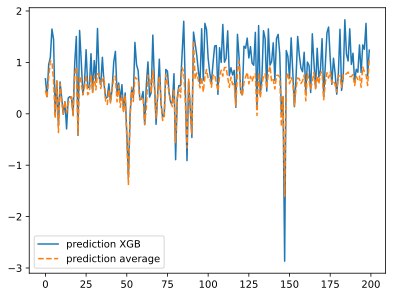

In [52]:
j= 0


plt.plot(range(200), Y_pred.loc[j,target[:200]], label="prediction XGB")
plt.plot(range(200), y_pred_av.loc[j,target[:200]],'--', label="prediction average")

plt.legend()
plt.show()

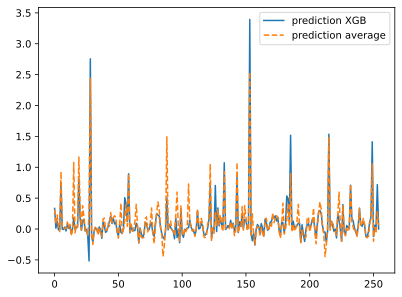

In [53]:
g = 1

plt.plot(range(len(Y_pred)), Y_pred.loc[:, target[g]], label="prediction XGB")
plt.plot(range(len(y_pred_av)), y_pred_av.loc[:,target[g]],'--', label="prediction average")

plt.legend()
plt.show()

In [54]:
Y_pred.to_csv('submission.csv')

In [55]:
!ls

__notebook__.ipynb  submission.csv


## Conclusions 

In this project, we employed an XGBoost model to address a high-dimensional multi-output regression problem to predict the differential expression of 18,211 genes across 6 cell types affected by 146 chemical substances. Our approach stands out for its computational efficiency and robustness to noise in the dataset, owing to its operation within a compressed space. Simultaneously, it is important to note that the accuracy of our method is constrained by information loss due to compression. 

As demonstrated, the impact of compounds on gene expression in a target cell type can be estimated by leveraging the average values for the other cells within the compressed space. This approximation can serve as a baseline model and be used for training advanced models in subsequent experiments, and it doesn't require any prior biological knowledge.



### Scores

| Model               | Public Score | Private Score |  CV Score |  
|---------------------|--------------|---------------|-----------|
| Baseline model #1   | 0.666        | 0.902         |  1.2818   |
| Model #2            | 0.624        | 0.818         |  1.0760   |
| Model #3            | 0.615        | 0.820         |  1.0717   |
| Model #4            | 0.594        | 0.777         |  0.9939   |



**Baseline model #1:** `y_pred` is all zeros

**Model #2:** TruncatedSVD (35 components) -> Inverse TruncatedSVD -> Aggregate Drugs -> .quantile(0.54)

**Model #3:** TruncatedSVD (36 components) -> Average for each drug ->  inverse TruncatedSVD 

**Model #4:** TruncatedSVD (n_components=36, n_iter=7) ->  TargetEncoder (smooting=8)  -> XGBoost (1000 estimators, feature augmentation with average for each drug) -> inverse TruncatedSVD 


## References 

We appreciate the authors of the following notebooks for sharing their work

[1] https://www.kaggle.com/code/ambrosm/scp-eda-which-makes-sense/notebook

[2] https://www.kaggle.com/code/alexandervc/op2-eda-baseline-s

[3] https://www.kaggle.com/code/alexandervc/op2-models-cv-tuning

[4] https://www.kaggle.com/code/ambrosm/scp-quickstart

Descriptions of the functions were created with help of ChatGPT.